In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
import xarray as xr
import xfeltor

plt.rcParams.update({'font.size': 22})
pd.set_option('display.float_format', lambda x: '%.2e' % x)

ATTENTION: possible bug introduced through wrong application of np.append method

In [2]:
data = simplesim.Manager( directory="./data", filetype="nc")
diag = simplesim.Manager( executable="./feltordiag.sh", directory="diag", filetype="nc")
plot = simplesim.Manager( executable ="./feltorplot.sh", directory="plot", filetype = "nc")

In [3]:
content = diag.table()
print( f"The database contains {np.size(content)} simulations")
i = 0
for file in content:
    
    print( diag.outfile( file), " split into ", diag.count( file), " file(s)", i)
    i+=1

The database contains 8 simulations
diag/07bb8c63064fff3844e807b59765c472390f380a.nc  split into  1  file(s) 0
diag/1e12d0ffd949e5264cd4cdec8aa6f94ef2fbd9fd.nc  split into  6  file(s) 1
diag/1f0eaf0c7fb6cdb7c9b90ba6d048be4ec9a70cd7.nc  split into  7  file(s) 2
diag/33752dd60b65c471ded739466e3f196ad1c410d9.nc  split into  9  file(s) 3
diag/415f7f4c866c5b5ca52190480827a8a1d0509c75.nc  split into  3  file(s) 4
diag/8ac4466911250523fd7d43a12a7b3fc69a6ee460.nc  split into  3  file(s) 5
diag/e83f3139cea7427f74a6039f13d57467b7841f3c.nc  split into  6  file(s) 6
diag/fc1fd9311d29a97b314cdfa6abf2a7f8ae199754.nc  split into  1  file(s) 7


In [4]:
config = fp.load_default_config()

with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [5]:
# for file in content :
# #     if file != content[6]:
# #         continue
#     for i in range( 0, data.count(file)) :
#         print( "Diag ", data.outfile( file), i)
#         diag.create(file,i,error="display")
# #         print( "Plot ", data.outfile( file), i)
# #         plot.create(file,i,error="display")

In [6]:
# def create_merged_dataset( manager, file ) :
#     datasetpaths = []
#     for i in range( 0, manager.count( file)) :
#         datasetpaths.append( manager.outfile( file, i) )
#     dataset = xr.open_mfdataset(datasetpaths, concat_dim='time', decode_times=False, join = "outer")
#     # dann brauchst du nen filter damit du die doppelten zeitschritte rausfilter kannst
#     filter = np.zeros_like(dataset["time"][:], dtype=bool)
#     filter[np.unique(dataset["time"][:], return_index=True)[1]] = True
#     return (dataset, filter)
#dann kannst du zb die zeit und masse als numpy array laden und damit hantieren
# (du kannst auch mit denen als xarray hantieren dafür gibts aber nicht alle numpy array funktionen ,
# dafür ist es wesentlich schneller!)
#time = np.asarray(dataset["time"][filter])
#mass = np.asarray(dataset["mass"][filter])


def create_merged_dataset( manager, file ) :
    datasetpaths = []
    for i in range( 0, manager.count( file)) :
        datasetpaths.append( manager.outfile( file, i) )
    return xfeltor.open_feltordataset( datasetpaths)


In [7]:
 # Temporary easy work with only one list element
full_content = diag.table()
content = []
content.append( full_content[1])
content.append( full_content[3])
content.append( full_content[4])
content.append( full_content[6])

In [8]:
min_idx = 50

### Mass flux out of separatrix

Invert for given numerical parameters
Average flux is 4.59e-04 pm 1.69e-04
Total average mass loss rate is 2259.5
Total mass gain by sources is 8387.4
particle confinement time = 1.99e+03


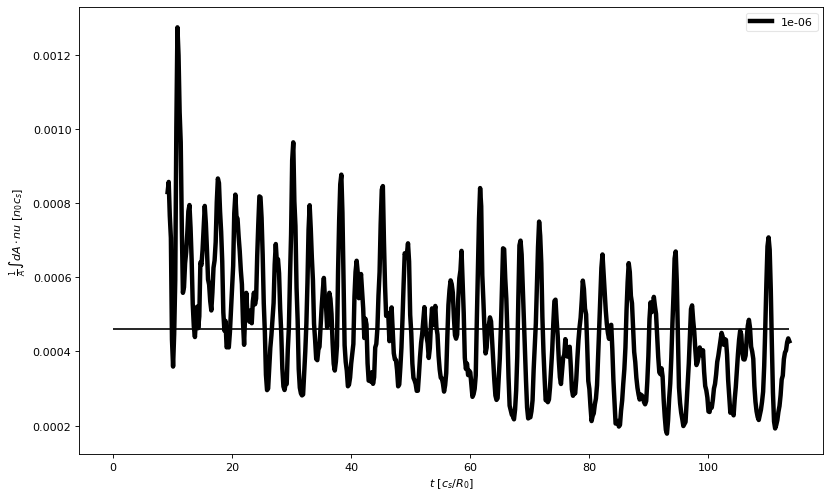

Invert for given numerical parameters
Average flux is 1.74e-03 pm 1.99e-04
Total average mass loss rate is 8573.1
Total mass gain by sources is 8387.4
particle confinement time = 4.88e+02


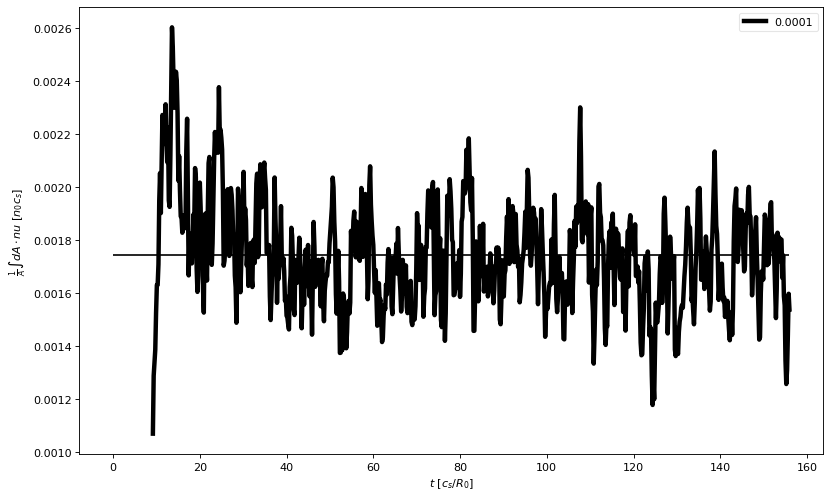

Invert for given numerical parameters
Average flux is 3.37e-03 pm 3.73e-04
Total average mass loss rate is 16577.3
Total mass gain by sources is 8387.4
particle confinement time = 2.41e+02


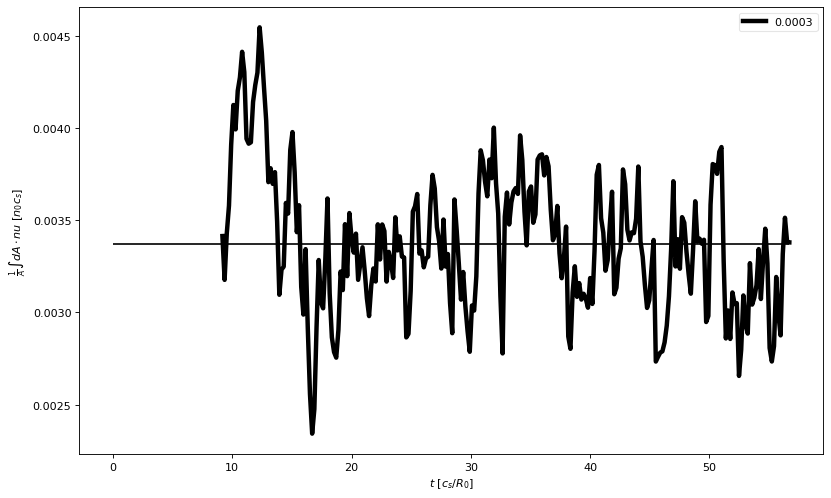

Invert for given numerical parameters
Average flux is 7.02e-04 pm 1.48e-04
Total average mass loss rate is 3451.2
Total mass gain by sources is 8387.4
particle confinement time = 1.27e+03


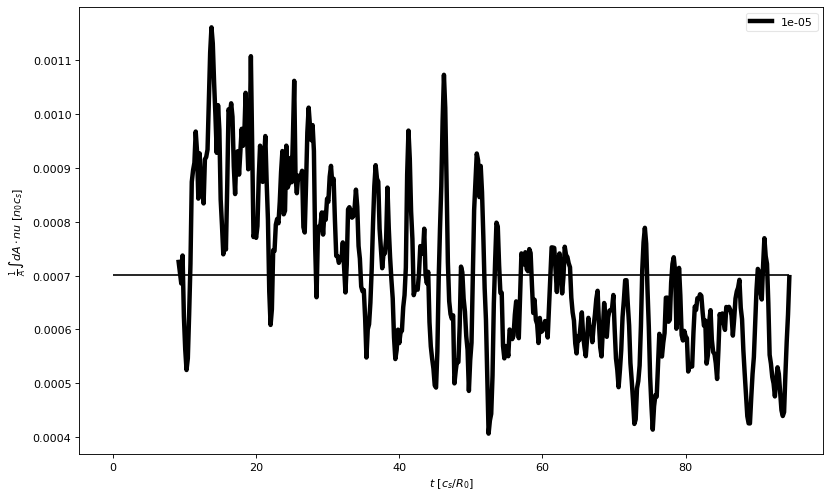

In [9]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion
resistivity = np.array([])
confinement_time = np.array([])
average_flux = np.array([])
total_flux = np.array([])
sigma_flux = np.array([])

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    #dd = Dataset( data.outfile(file), 'r')
    #da = Dataset( diag.outfile(file), "r")
    da = create_merged_dataset( diag, file)
    da0 = Dataset( diag.outfile( file, 0), 'r')
    #pl = nc.Dataset( plot.outfile(file), "r")
    
    #print( dset)
    pp = json.loads( da.inputfile )
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    rho = da0['rho'][:]
    rho_t = da0['rho_t'][:]
    rho_p = da0['rho_p'][:]
    lcfs = np.argmax( rho_t[np.where( rho_t < 1)])
    idx = lcfs
    area = da0['psi_area'][:]
    volume = da0['psi_vol'][:]
    
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
#     print( pp["physical"])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['electrons_ifs_lcfs'][:])
    average_mass = np.mean(mass)
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    # jvne= dset.variables['jvneE_tt_fsa'][:,:]
    jvne=np.asarray(da['jvneC_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['jvneE_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(da['jvneA_tt_ifs_lcfs'][:])/deltat
    divjvne = np.asarray(da["divjnepar_tt_ifs_lcfs"][:])/deltat
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    source = np.asarray(da["sne_tt_ifs_lcfs"][:])/deltat
    average_source = source[min_idx:].mean()
    resistivity = np.append( resistivity, pp["physical"]["resistivity"])
    print( f"Average flux is { average_jvne/area[idx]:1.2e} pm {sigma_jvne/area[idx]:1.2e}")
    print( f"Total average mass loss rate is {average_jvne:6.1f}")
    print( f"Total mass gain by sources is {average_source:6.1f}" )
    average_flux = np.append( average_flux, average_jvne/area[idx] )
    total_flux = np.append( total_flux, average_jvne)
    sigma_flux = np.append(sigma_flux, sigma_jvne/area[idx] )
    print( f"particle confinement time = {average_mass/average_jvne*timescale:1.2e}")
    confinement_time = np.append( confinement_time, average_mass/average_jvne*timescale )
    tau = mass/jvne

    plt.plot(time[min_idx:]*timescale,jvne[min_idx:]/area[idx], color='k', 
             marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, 
             label=f'{pp["physical"]["resistivity"]}')
    plt.hlines(average_jvne/area[idx], time[0]*timescale, time[len(time)-1]*timescale, color='k')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")

    plt.show(   )


Resistivity  [1.e-06 1.e-04 3.e-04 1.e-05]
Average flux  [0.00045941 0.00174308 0.00337049 0.00070169]
Total flux  [ 2259.52900138  8573.08591309 16577.27742162  3451.15819593]
Sigma flux  [0.00016886 0.00019926 0.00037328 0.00014846]
Confinement time  [1992.92680683  487.95738072  240.78262535 1274.41383792]


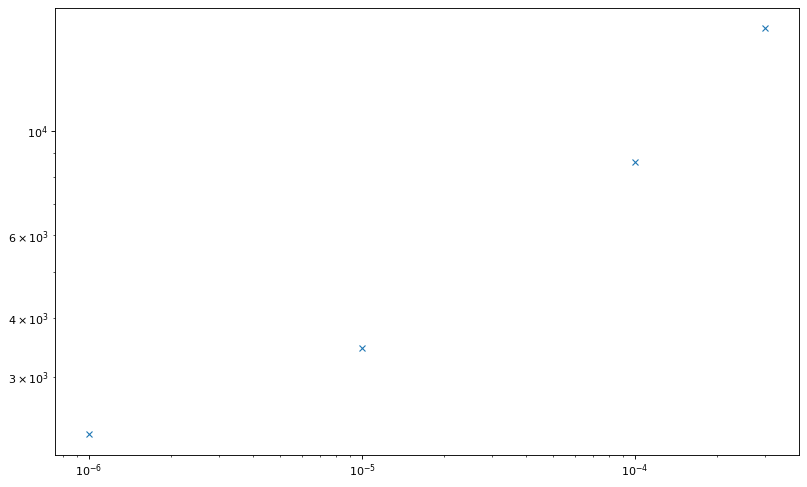

In [10]:
print( "Resistivity ", resistivity)
print( "Average flux ", average_flux)
print( "Total flux ", total_flux)
print( "Sigma flux ", sigma_flux)
print( "Confinement time ", confinement_time)

fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
plt.plot(resistivity, total_flux, marker='x', ls='')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

### Volume Integrated Mass conservation

Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  -74.93281089438356


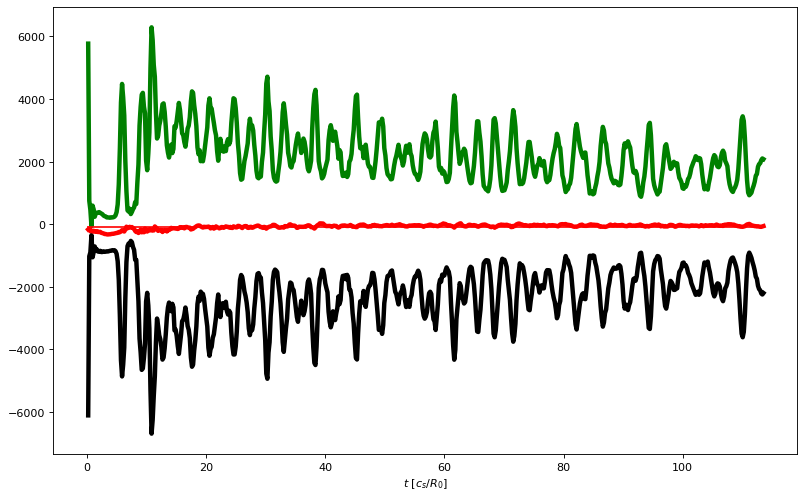

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  44.91299571626448


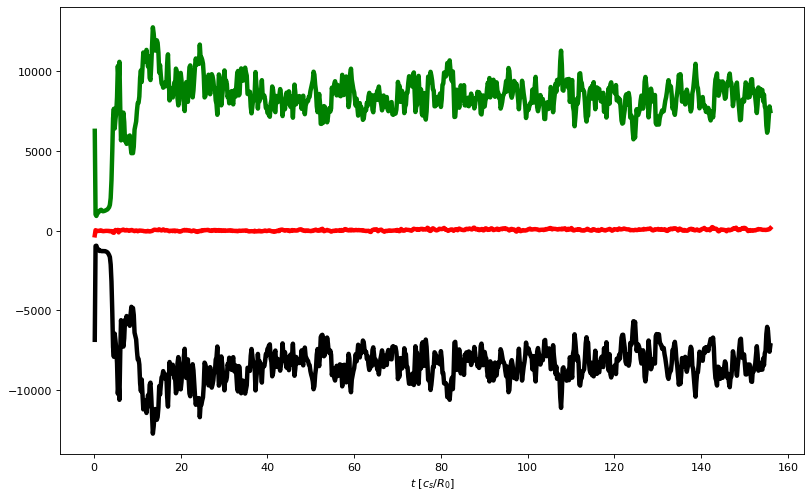

Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  117.00058646146083


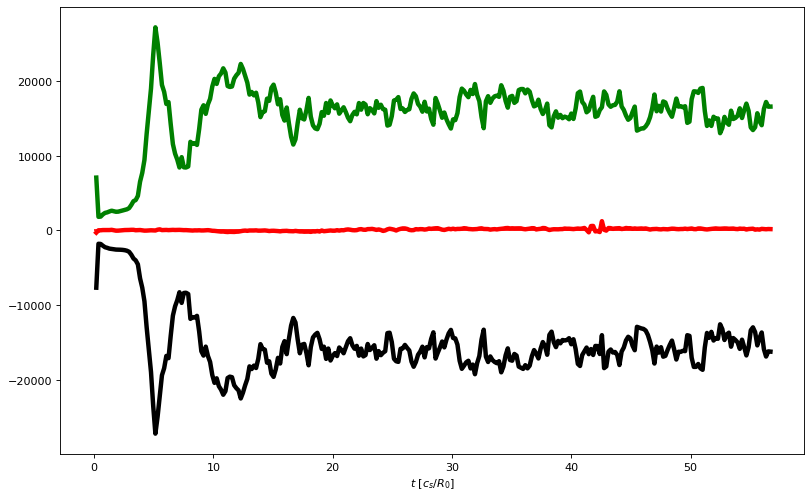

Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  -46.208238751899366


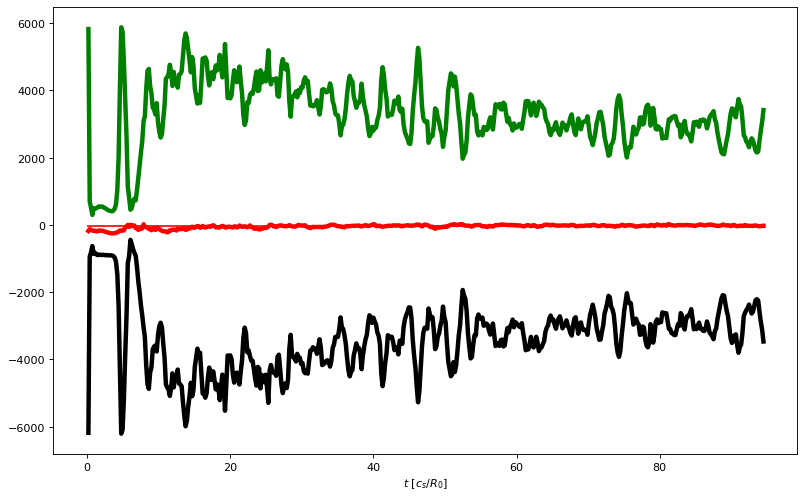

In [12]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    #dset = Dataset( diag.outfile(file), 'r')
    dset = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )
    time = np.asarray(dset['time'][:])
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    mass = np.asarray(dset.variables['electrons_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)

    deltamass = np.diff(masstt,axis=0)/deltat
    source = np.asarray(dset.variables['sne_tt_ifs_lcfs'][:])/deltat
    deltamass-=source
    jvne= np.asarray(dset['jvneE_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(dset['jvneC_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(dset['jvneA_tt_ifs_lcfs'][:])/deltat
    divjvnepar=np.asarray(dset['divjnepar_tt_ifs_lcfs'][:])/deltat
    #jvne+=divjvnepar

    diff_perp = np.asarray(dset["lneperp_tt_ifs_lcfs"][:])/deltat
    diff_para = np.asarray(dset["lneparallel_tt_ifs_lcfs"][:])/deltat
    rhs = jvne-diff_perp-diff_para
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean(diff[1:])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,deltamass[1:], color='k', marker='',
              ls='-', lw=4,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=4,markeredgecolor='g', markersize=8, label="rhs")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=4,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
#     plt.plot(time[min_idx:]*timescale,divjvnepar[min_idx:], color='g', marker='',
#              ls='--', lw = 4, label="parallel")

    dset.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )

## Energy conservation

Invert for given numerical parameters
Average flux is 5.22e-04 pm 2.56e-04
Total average mass loss rate is 2568.9
Total mass gain by sources is 55880.2
particle confinement time = 1.01e+02


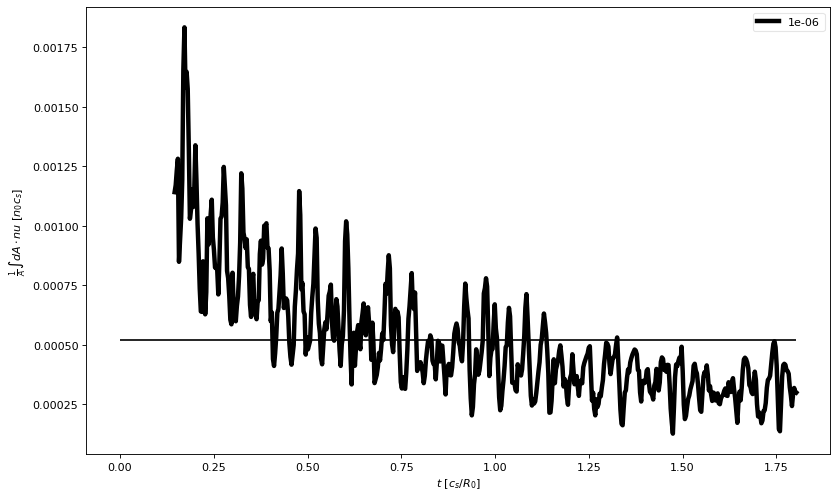

Invert for given numerical parameters
Average flux is 3.44e-03 pm 4.52e-04
Total average mass loss rate is 16920.5
Total mass gain by sources is 53305.9
particle confinement time = 1.33e+01


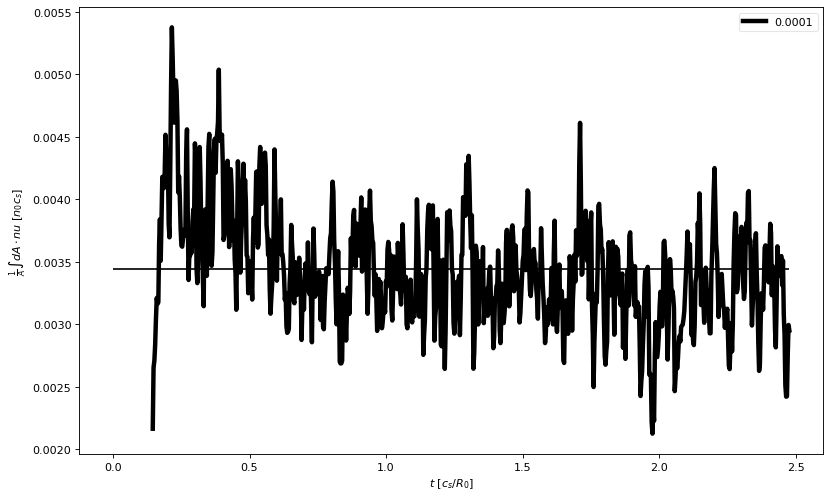

Invert for given numerical parameters
Average flux is 8.46e-03 pm 9.77e-04
Total average mass loss rate is 41596.3
Total mass gain by sources is 50749.3
particle confinement time = 4.89e+00


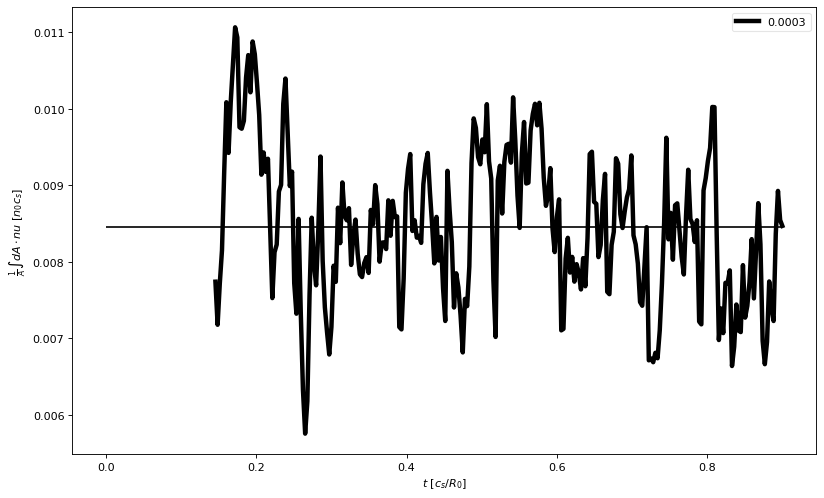

Invert for given numerical parameters
Average flux is 9.80e-04 pm 3.06e-04
Total average mass loss rate is 4822.2
Total mass gain by sources is 54988.8
particle confinement time = 5.12e+01


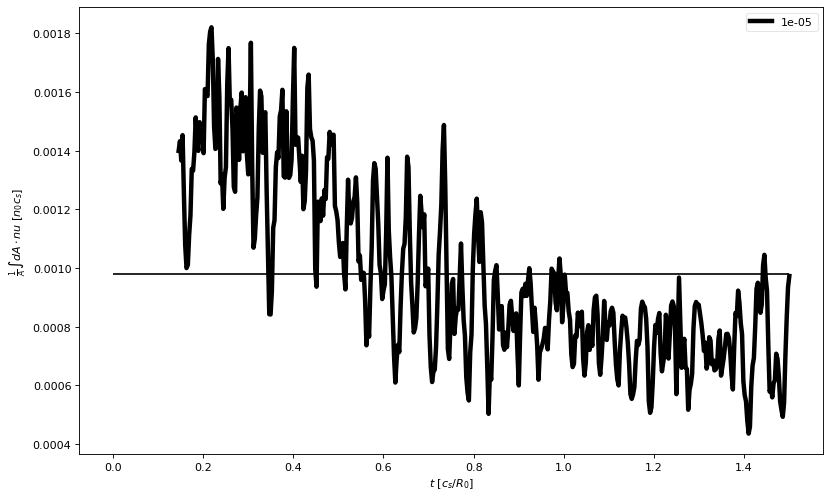

In [13]:
# Observations: 
# - jvne is larger than perpendicular diffusion
# - perpendicular diffusion is larger than parallel diffusion
resistivity = np.array([])
confinement_time = np.array([])
average_flux = np.array([])
total_flux = np.array([])
sigma_flux = np.array([])

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')

    da = create_merged_dataset( diag, file)
    da0 = Dataset( diag.outfile( file, 0), 'r')
 
    pp = json.loads( da.inputfile )
    time = np.asarray(da['time'][:])
    #print( time)
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    rho = da0['rho'][:]
    rho_t = da0['rho_t'][:]
    rho_p = da0['rho_p'][:]
    lcfs = np.argmax( rho_t[np.where( rho_t < 1)])
    idx = lcfs
    area = da0['psi_area'][:]
    volume = da0['psi_vol'][:]
    
    num = {"R_0" : pp["magnetic_field"]['params']["R_0"], **pp["physical"]}
    fp.numerical2physical( num, pp['physical'])
#     print( pp["physical"])
    timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
#     timescale = 1/num['R_0']# in cs/R_0  
#     timescale = 1
    fluxscale = fp.c_s(**pp['physical'])*pp['physical']['n_0']
    
    mass =np.asarray(da['ue2_ifs_lcfs'][:])
    mass+=np.asarray(da['nelnne_ifs_lcfs'][:])
    mass+=np.asarray(da['nilnni_ifs_lcfs'][:])
    mass+=np.asarray(da['neue2_ifs_lcfs'][:])
    mass+=np.asarray(da['niui2_ifs_lcfs'][:])
    mass+=np.asarray(da['aperp2_ifs_lcfs'][:])
    average_mass = np.mean(mass)
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt)/deltat

    jvne = da.variables['jvee_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jvei_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jveea_tt_ifs_lcfs'][:]/deltat
    jvne+= da.variables['jveia_tt_ifs_lcfs'][:]/deltat
    average_jvne = np.mean(jvne[min_idx:]) # don't keep initial phase in statistics
    sigma_jvne = jvne[min_idx:].std()
    source =da.variables['see_tt_ifs_lcfs'][:]/deltat
    source+=da.variables['sei_tt_ifs_lcfs'][:]/deltat
    average_source = source[min_idx:].mean()
    resistivity = np.append( resistivity, pp["physical"]["resistivity"])
    print( f"Average flux is { average_jvne/area[idx]:1.2e} pm {sigma_jvne/area[idx]:1.2e}")
    print( f"Total average mass loss rate is {average_jvne:6.1f}")
    print( f"Total mass gain by sources is {average_source:6.1f}" )
    average_flux = np.append( average_flux, average_jvne/area[idx] )
    total_flux = np.append( total_flux, average_jvne)
    sigma_flux = np.append(sigma_flux, sigma_jvne/area[idx] )
    print( f"particle confinement time = {average_mass/average_jvne*timescale:1.2e}")
    confinement_time = np.append( confinement_time, average_mass/average_jvne*timescale )
    tau = mass/jvne

    plt.plot(time[min_idx:]*timescale,jvne[min_idx:]/area[idx], color='k', 
             marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, 
             label=f'{pp["physical"]["resistivity"]}')
    plt.hlines(average_jvne/area[idx], time[0]*timescale, time[len(time)-1]*timescale, color='k')

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot nu\ [n_0c_s]$")

    plt.show(   )


Resistivity  [1.e-06 1.e-04 3.e-04 1.e-05]
Average flux  [0.0005223  0.00344028 0.00845736 0.00098046]
Total flux  [ 2568.85675613 16920.51935354 41596.27774908  4822.24746304]
Sigma flux  [0.00025638 0.00045233 0.00097689 0.0003059 ]
Confinement time  [100.59439163  13.30678548   4.88921437  51.15731536]


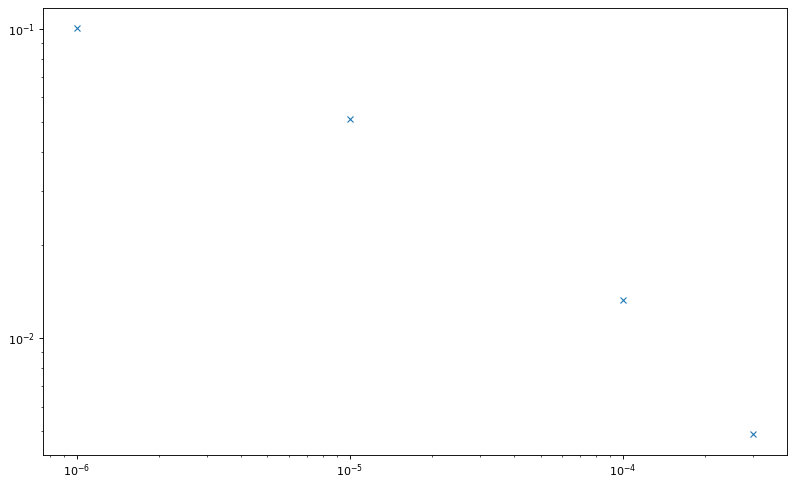

In [14]:
print( "Resistivity ", resistivity)
print( "Average flux ", average_flux)
print( "Total flux ", total_flux)
print( "Sigma flux ", sigma_flux)
print( "Confinement time ", confinement_time)

fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
plt.plot(resistivity, confinement_time*1e-3, marker='x', ls='')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  -76.83436095475


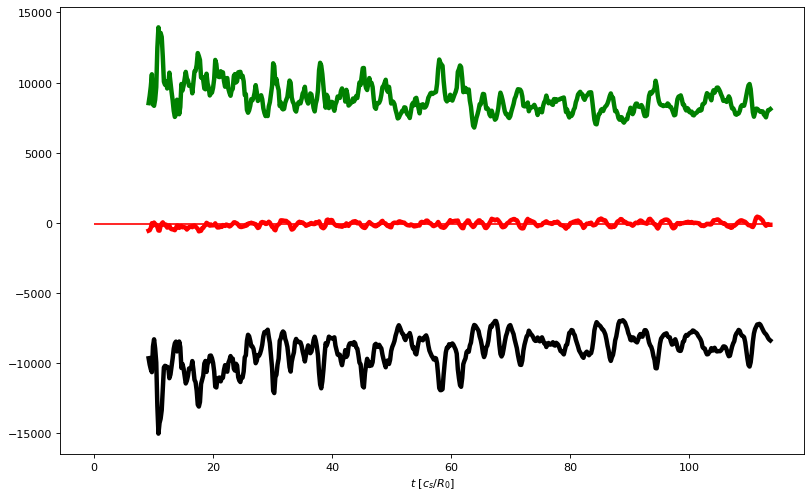

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  -597.0424615435043


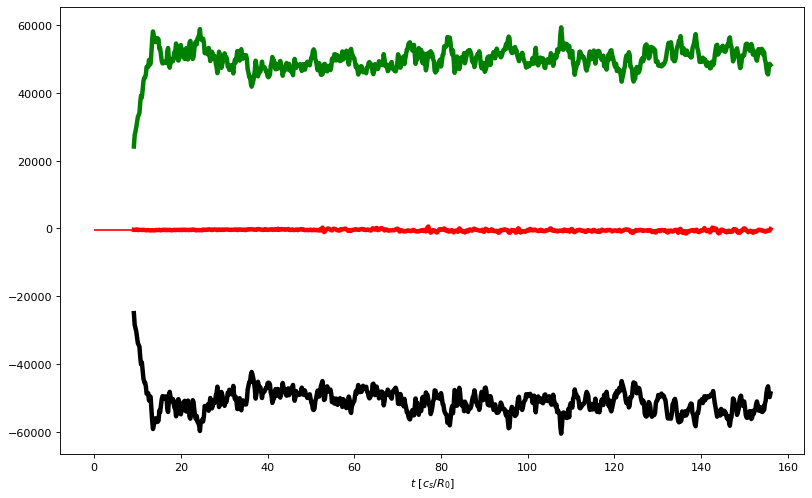

Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  -1190.1804113907135


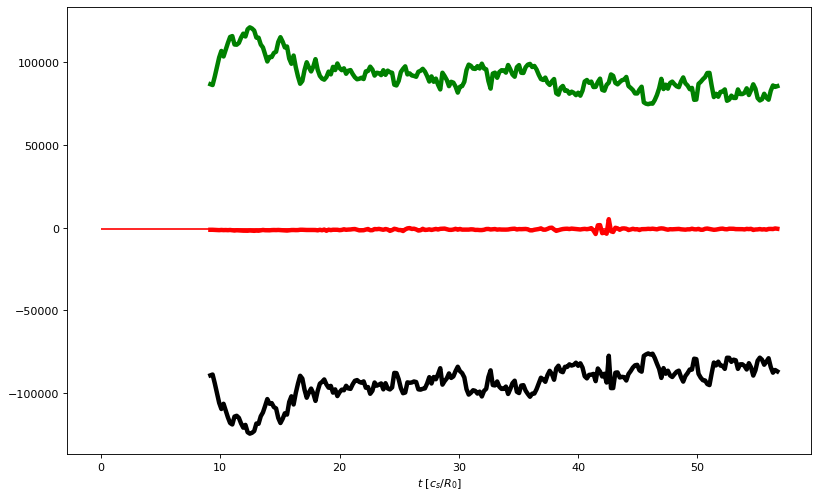

Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  -187.46875997081014


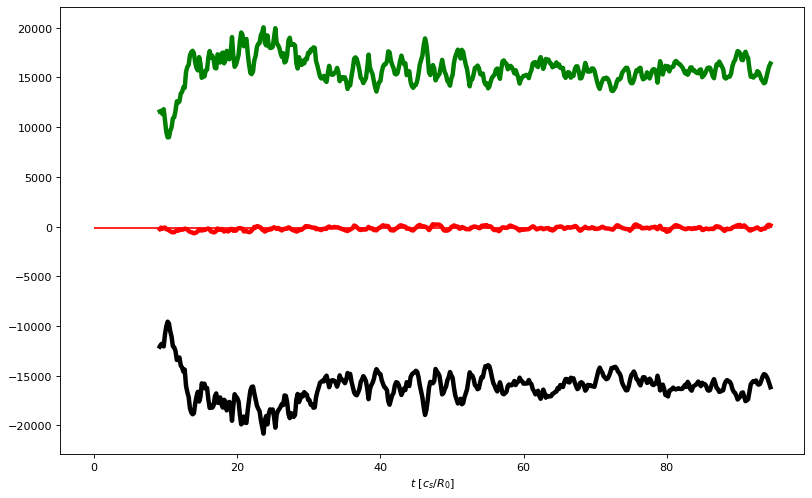

In [15]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    #dset = Dataset( diag.outfile(file), 'r')
    dset = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )
    time = np.asarray(dset['time'][:])
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    mass =np.asarray(dset['ue2_ifs_lcfs'][:])
    mass+=np.asarray(dset['nelnne_ifs_lcfs'][:])
    mass+=np.asarray(dset['nilnni_ifs_lcfs'][:])
    mass+=np.asarray(dset['neue2_ifs_lcfs'][:])
    mass+=np.asarray(dset['niui2_ifs_lcfs'][:])
    mass+=np.asarray(dset['aperp2_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)

    deltamass = np.diff(masstt,axis=0)/deltat
    source =np.asarray(dset.variables['see_tt_ifs_lcfs'][:])/deltat
    source+=np.asarray(dset.variables['sei_tt_ifs_lcfs'][:])/deltat
    deltamass-=source
    jvne = np.asarray(dset.variables['jvee_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(dset.variables['jvei_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(dset.variables['jveea_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(dset.variables['jveia_tt_ifs_lcfs'][:])/deltat

    diff_perp = np.asarray(dset.variables["leeperp_tt_ifs_lcfs"][:])/deltat
    diff_para = np.asarray(dset.variables["leeparallel_tt_ifs_lcfs"][:])/deltat
    diff_perp+= np.asarray(dset.variables["leiperp_tt_ifs_lcfs"][:])/deltat
    diff_para+= np.asarray(dset.variables["leiparallel_tt_ifs_lcfs"][:])/deltat
    resistive = np.asarray(dset.variables['resistivity_tt_ifs_lcfs'][:])/deltat
    rhs = jvne-diff_perp-diff_para-resistive
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[min_idx:]*timescale,deltamass[min_idx:], color='k', marker='',
              ls='-', lw=4,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[min_idx:]*timescale,rhs[min_idx:], color='g', marker='',
              ls='-', lw=4,markeredgecolor='g', markersize=8, label="rhs")
    plt.plot(time[min_idx:]*timescale,diff[min_idx:], color='r', marker='',ls='-', 
              lw=4,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
#     plt.plot(time[min_idx:]*timescale,divjvnepar[min_idx:], color='g', marker='',
#              ls='--', lw = 4, label="parallel")

    dset.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )

### Average FSA Mass conservation 

Resistivity = 1e-06
Average diff =  1.849251509737975e-06
Average std  =  4.250277352917976e-06
Resistivity = 0.0001
Average diff =  1.6835785641118723e-06
Average std  =  2.82104688352846e-06
Resistivity = 0.0003
Average diff =  1.3325834419653574e-06
Average std  =  2.7993340431132457e-06
Resistivity = 1e-05
Average diff =  1.6633221067405266e-06
Average std  =  3.8088222242506404e-06


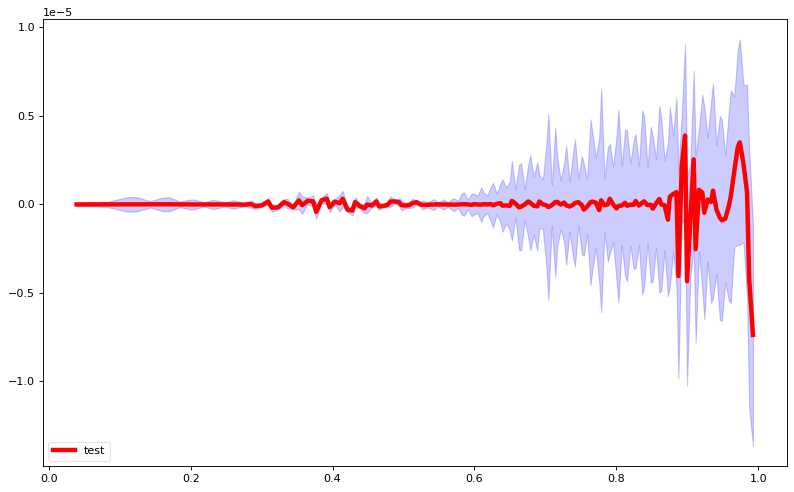

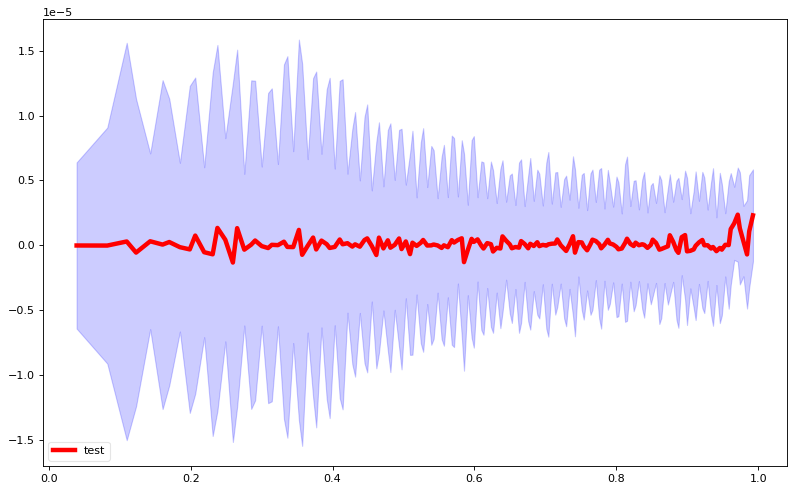

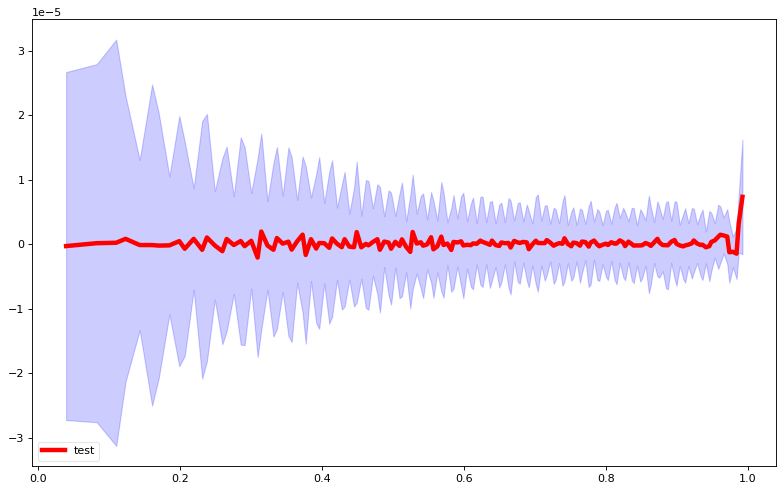

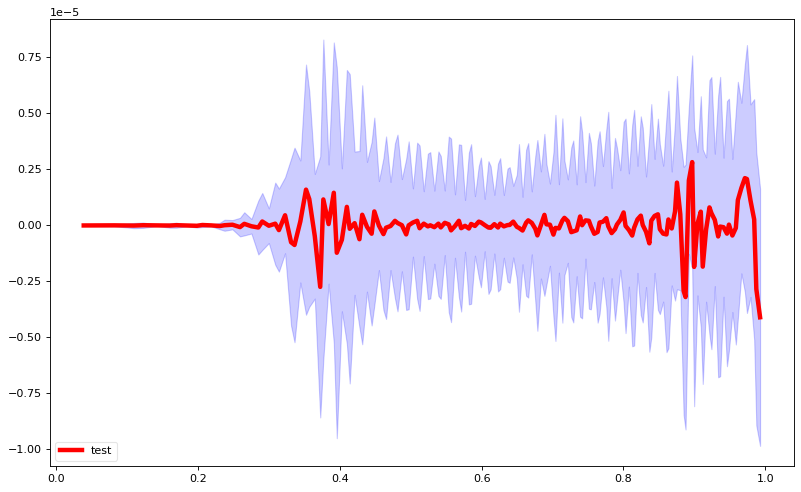

In [16]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    #dset = Dataset( diag.outfile(file), 'r')
    
    dset = create_merged_dataset( diag, file)
    params = json.loads(dset.inputfile)
    mass =np.asarray(dset.variables['electrons_fsa'][:,:])
    time = np.asarray(dset.variables['time'][:])
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = np.asarray(dset.variables['sne_tt_fsa'][:,:])/deltat[:,None]
    deltamass-=source

    jvneC=np.asarray(dset.variables['jvneC_tt_ifs'][:,:])/deltat[:,None]
    jvneE=np.asarray(dset.variables['jvneE_tt_ifs'][:,:])/deltat[:,None]
    jvneA=np.asarray(dset.variables['jvneA_tt_ifs'][:,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = np.asarray(dset.variables["lneperp_tt_fsa"][:,:])/deltat[:,None]
    diff_parallel = np.asarray(dset.variables["lneparallel_tt_fsa"][:,:])/deltat[:,None]
    rhs = jvne-diff_perp-diff_parallel
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])

    plt.plot( rho_t[0:167], average_diff[0:167], ls = '-', color='r', lw = 4, label = 'test')
    plt.fill_between( rho_t[0:167], average_diff[0:167]-average_std[0:167], 
                      average_diff[0:167]+average_std[0:167], color='b', alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()

### Local Mass conservation on LCFS

Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  0.0010078420728071985
Average std  =  0.002316401157340293
Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  0.0009175503174409686
Average std  =  0.0015374705515230106
Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  0.0007262579758711198
Average std  =  0.001525637053496719
Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  0.0009065105481735876
Average std  =  0.0020758081122166


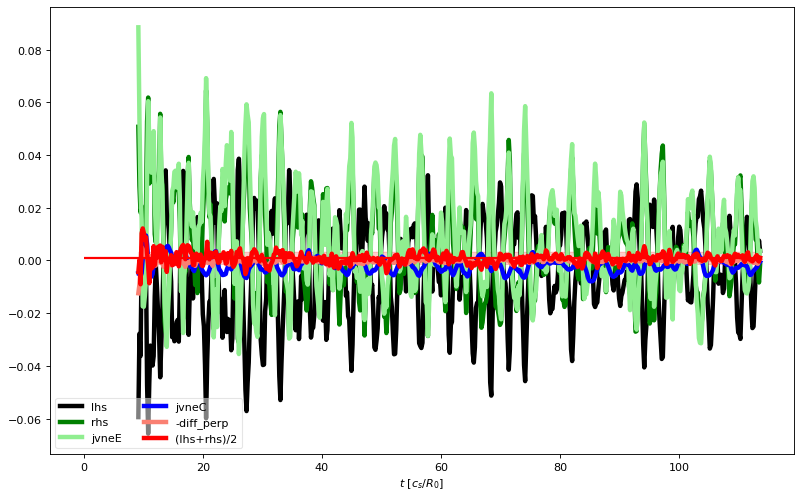

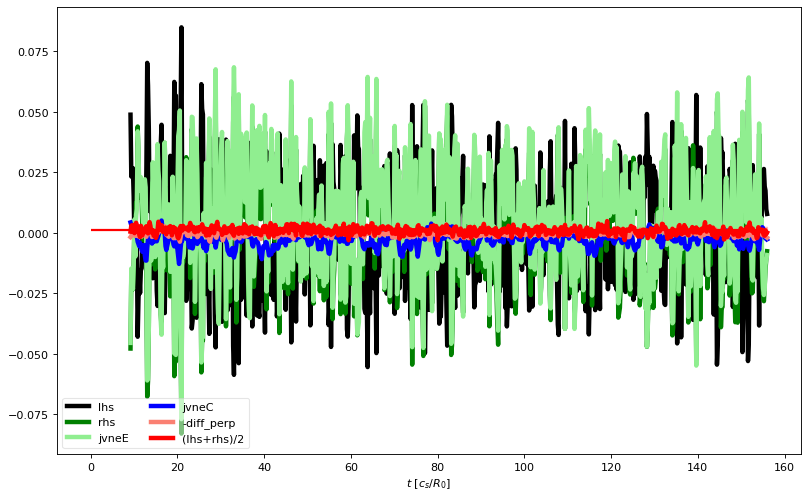

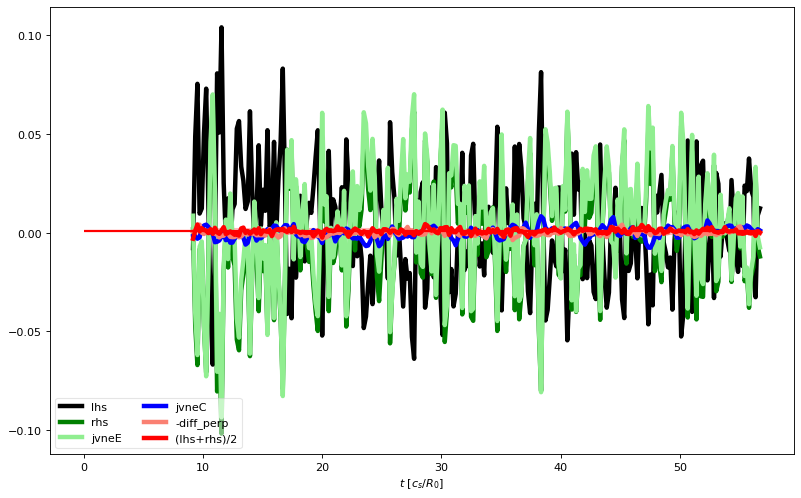

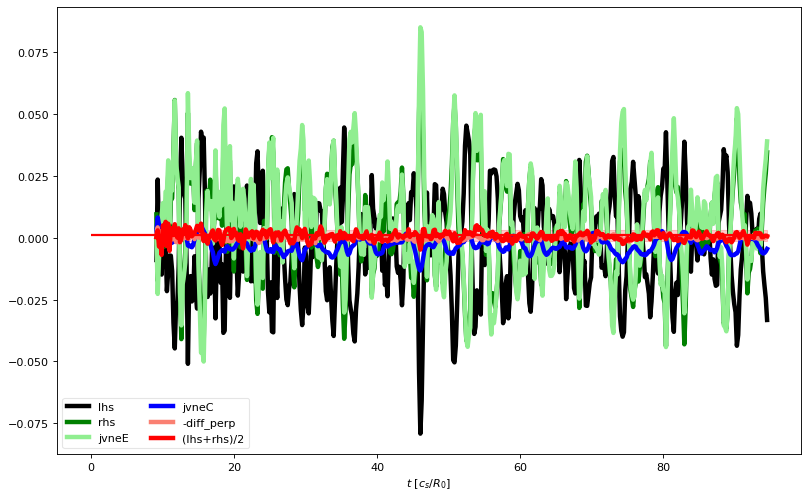

In [17]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    dset = create_merged_dataset( diag, file)
    params= json.loads(dset.inputfile)
    mass =np.asarray(dset.variables['electrons_fsa'][:,:])
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    time = np.asarray(dset.variables['time'][:])*timescale
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    masstt=np.append(np.zeros((1,len(rho))),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat[:,None]
    source = np.asarray(dset.variables['sne_tt_fsa'][:,:])/deltat[:,None]
    deltamass-=source

    jvneC=np.asarray(dset.variables['jvneC_tt_ifs'][:,:])/deltat[:,None]
    jvneE=np.asarray(dset.variables['jvneE_tt_ifs'][:,:])/deltat[:,None]
    jvneA=np.asarray(dset.variables['jvneA_tt_ifs'][:,:])/deltat[:,None]
    jvne = jvneC+jvneE+jvneA
    
    diff_perp = np.asarray(dset.variables["lneperp_tt_fsa"][:,:])/deltat[:,None]
    diff_parallel = np.asarray(dset.variables["lneparallel_tt_fsa"][:,:])/deltat[:,None]
    rhs = jvne-diff_perp-diff_parallel
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean( diff[1:], axis=0)
    average_std =  np.std( diff[1:], axis=0)
    idx=160
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    plt.plot(time[min_idx:],deltamass[min_idx:,idx], color='k', marker='',
              ls='-',lw=4, label="lhs")
    plt.plot(time[min_idx:],rhs[min_idx:,idx], color='g',
              ls='-', lw = 4,  label="rhs")
    plt.plot(time[min_idx:],jvneE[min_idx:,idx], color='lightgreen',
              ls='-', lw = 4, label="jvneE")
    plt.plot(time[min_idx:],jvneC[min_idx:,idx], color='blue',
              ls='-', lw = 4, label="jvneC")
    plt.plot(time[min_idx:],-diff_perp[min_idx:,idx], color='salmon',
              ls='-', lw = 4,  label="-diff_perp")
    plt.plot(time[min_idx:],diff[min_idx:,idx], color='r',
              ls='-', lw = 4,  label="(lhs+rhs)/2")
    plt.hlines(average_diff[idx], time[0], time[len(time)-1], color='r', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    plt.xlabel(r"$t\ [c_s/R_0]$")

### Density profile

Invert for given numerical parameters
Resistivity = 1e-06
Dataset length  620
Average region  9.174311926605505 113.57798165137615
Invert for given numerical parameters
Resistivity = 0.0001
Dataset length  851
Average region  9.174311926605505 155.9633027522936
Invert for given numerical parameters
Resistivity = 0.0003
Dataset length  310
Average region  9.174311926605505 56.69724770642202
Invert for given numerical parameters
Resistivity = 1e-05
Dataset length  516
Average region  9.174311926605505 94.49541284403671


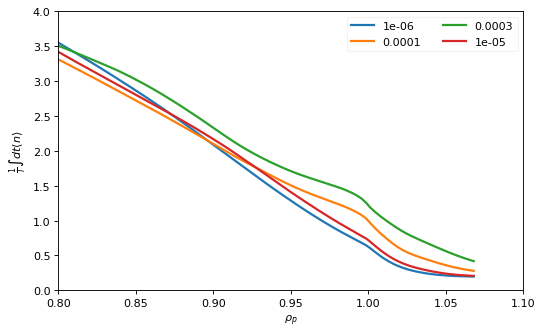

In [18]:

fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
for file in content :


    dset = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )

    time = np.asarray(dset.variables['time'][:])

    density =dset.variables['electrons_fsa'][:]
    source = dset.variables['sne_tt_fsa'][:]
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Dataset length ", len(time))
    print( "Average region ", time[min_idx]*timescale, time[len(time)-1]*timescale)
    avg_density=density[min_idx:len(time)-1].mean(axis=0)
    avg_source = source.mean(axis=0)
    plt.plot( rho_p, avg_density, ls='-', lw=2, label=f'{params["physical"]["resistivity"]}')
    # plt.plot( rho_t, density[len(time)-1,:],color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( rho_t, avg_source*1000,color=v[0],ls='-', lw=2, label=v[1] )
    # plt.plot( rho_t,   -psi_p*3+1, ls='--', color = 'k')
#     plt.plot( rho_p,   -psi_p/2+1, ls='--', color = 'k')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.25)
    dset.close()
ax.axvspan(0, 0.4, alpha=0.25, color='red')

plt.xlabel(r"$\rho_p$")
# plt.xlabel(r"$\sqrt{\psi_p/\psi_{O}}$")

plt.ylabel(r"$\frac{1}{T}\int dt \langle n\rangle$")
plt.xlim(0.8,1.1)
plt.ylim(0,4)
plt.show(  )

### Vorticity accuracy on LCFS

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 1e-06
Average diff =  2.177008426968504e-06
Average std  =  2.319377651512574e-06


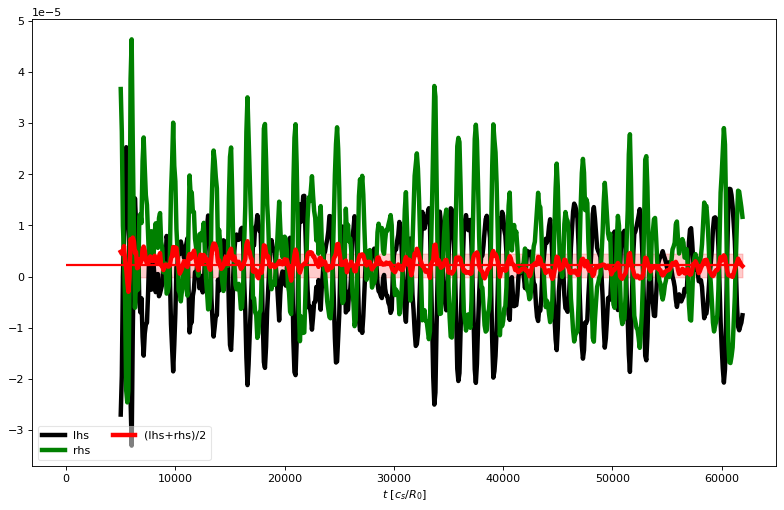

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 0.0001
Average diff =  5.700185713954006e-06
Average std  =  2.052466804620217e-06


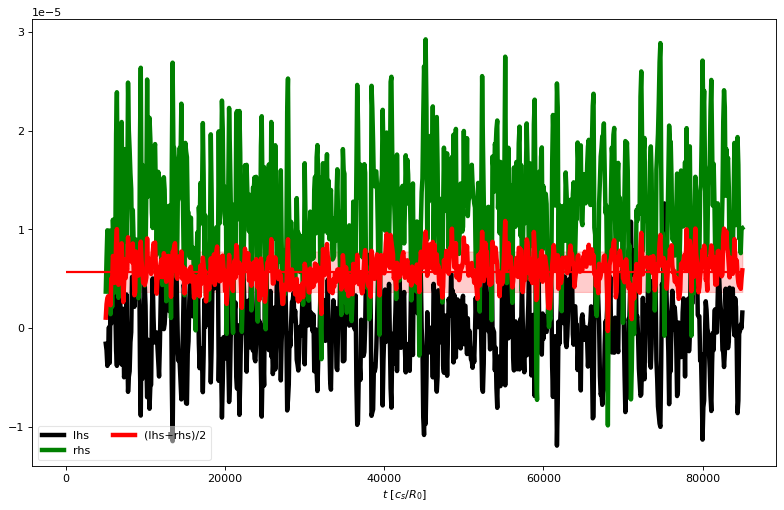

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 0.0003
Average diff =  8.911560116595707e-06
Average std  =  2.741615216500018e-06


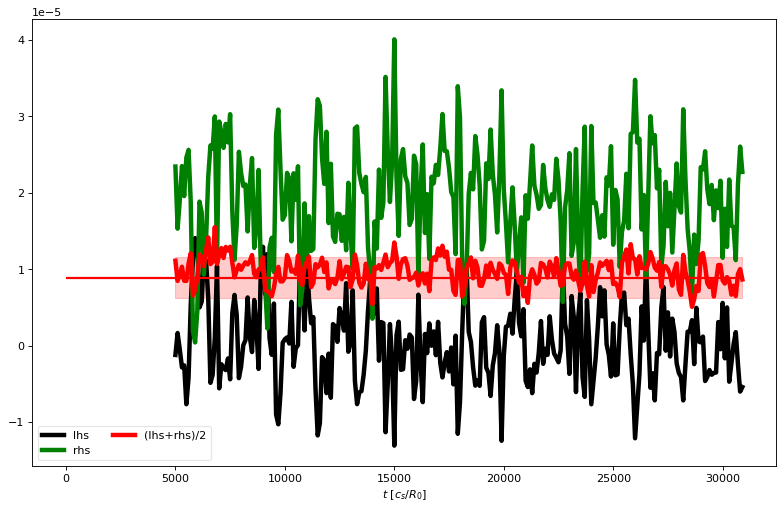

Invert for given numerical parameters
Index 167 vs lcfs 167
167
0.9982504105290998
Resistivity = 1e-05
Average diff =  3.5067148655508796e-06
Average std  =  2.0581931828031737e-06


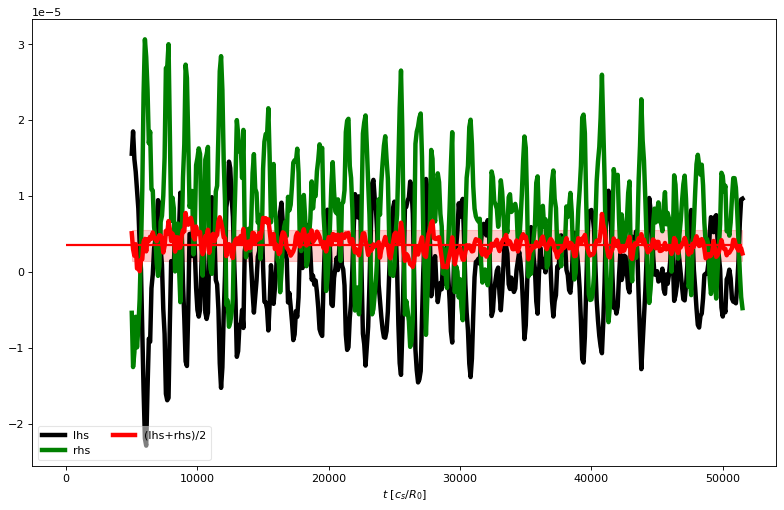

In [19]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    dset = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )
    time = np.asarray(dset['time'][:])
    timett = np.append(2*time[len(time)-1] -time[len(time)-2], time ) # extrapolate
    deltat = np.diff(timett)
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0   
#     vorticity = dset['vorticity_fsa'][:,:]
#     el = dset['electrons_ifs'][:,:]
#     ions = dset['ions_ifs'][:,:]
#     dvdpsip=dset['dvdpsi'][:]
#     vorticity = (el-ions)/dvdpsip
    vorticity =np.asarray(dset['oexbe_fsa'][:,:])
    # vorticity+=dset['odiae_fsa'][:,:]
    # vorticity/=dset['electrons_fsa'][:,:]
    tttvorticity=np.append(np.zeros((1,len(rho_t))),vorticity, axis=0)
    deltavorticity = np.diff(tttvorticity,axis=0)/deltat[:,None]
    jvoE= np.asarray(dset['jvoexbe_tt_ifs'][:,:])/deltat[:,None]
    jvoD= np.asarray(dset['jvoexbeUD_tt_ifs'][:,:])/deltat[:,None]
    # jvoD= dset.variables['jvodiaeUE_tt_ifs'][:,:]/deltat[:,None]
    maxwell= np.asarray(dset['jvoapar_tt_ifs'][:,:])/deltat[:,None]
    jvoA= np.asarray(dset['jvoexbApar_tt_ifs'][:,:])/deltat[:,None]
    # jvoA= dset['jvodiaApar_tt_ifs'][filter,:]/deltat[:,None]
    jvo = jvoE + jvoD + maxwell + jvoA
    force = -np.asarray(dset["socurve_tt_fsa"][:,:])/deltat[:,None]
    force -= np.asarray(dset["socurvi_tt_fsa"][:,:])/deltat[:,None]
    force -= np.asarray(dset["socurvkappae_tt_fsa"][:,:])/deltat[:,None]
    force -= np.asarray(dset["socurvkappai_tt_fsa"][:,:])/deltat[:,None]
    # force2 = -dset["curvne_tt_ifs"][:,:]/deltat[:,None]/dvdpsi[:]
    # source = dset["sosne_tt_fsa"][:,:]/deltat[:,None]
    # source+= dset["sospi_tt_fsa"][:,:]/deltat[:,None]
    lamb = np.asarray(dset["loexbe_tt_fsa"][:,:])/deltat[:,None]
    #lamb = dset['lneperp_tt_ifs'][:,:]/deltat[:,None]

    #lamb = lamb/dvdpsip[None,:]

    rhs = jvo+force-lamb#-source
    # diff = +deltavorticity + rhs
    diff = (deltavorticity +rhs)/2
    # delayed_diff = (deltavorticity[0:-1,:]+rhs[1:,:])/2
    average_diff = np.mean( diff[1:], axis=0)
    average_std = np.std( diff[1:], axis=0)
    # rhs = rhs - 2*average_diff[None, :]
    # diff = ( deltavorticity + rhs)/2
    
    lcfs = np.argmax( rho_t[np.where( rho_t < 1)])
    print( "Index 167 vs lcfs", lcfs)
    idx= 167
    print( idx)
    print( rho_t[idx])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff[idx])
    print( "Average std  = ", average_std[idx])
    plt.plot(time[min_idx:],deltavorticity[min_idx:,idx], color='k', marker='',
              ls='-',lw=4,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[min_idx:],rhs[min_idx:,idx], color='g', marker='',
              ls='-', lw = 4, markeredgecolor='k', markersize=8, label="rhs")
    plt.plot(time[min_idx:],diff[min_idx:,idx], color='r', marker='',
              ls='-', lw = 4, markeredgecolor='k', markersize=8, label="(lhs+rhs)/2")
#     plt.plot(time[min_idx:],10*jvoE[min_idx:,idx], color='salmon', marker='',
#               ls='-',lw=4,markeredgecolor='k', markersize=8, label="jvoE")
#     plt.plot(time[min_idx:],10*jvoD[min_idx:,idx], color='lightblue', marker='',
#               ls='-',lw=4,markeredgecolor='k', markersize=8, label="jvoD")
#     # plt.plot(time[min_idx:],-source[min_idx:,idx], color='crimson', marker='',
#     #           ls='-', lw = 4, markeredgecolor='k', markersize=8, label="-source")
#     plt.plot(time[min_idx:],force[min_idx:,idx], color='y', marker='',
#               ls='-', lw = 4, markeredgecolor='k', markersize=8, label="force")
#     plt.plot(time[min_idx:],jvoA[min_idx:,idx], color='orange', marker='',
#               ls='-', lw = 4, markeredgecolor='k', markersize=8, label="jvoA")
#     plt.plot(time[min_idx:],maxwell[min_idx:,idx], color='pink', marker='',
#               ls='-', lw = 4, markeredgecolor='k', markersize=8, label="Maxwell")
    # plt.plot(time[min_idx:],-lamb[min_idx:,idx], color='lightyellow', marker='',
    #           ls='-', lw = 4, markeredgecolor='k', markersize=8, label="-lambda")
    plt.hlines(average_diff[idx], time[0], time[len(time)-1], color='r', lw=2 )
    plt.fill_between( time[min_idx:], average_diff[idx]-average_std[idx], 
                      average_diff[idx]+average_std[idx], color='red', alpha=0.2)

    # print(time[len(time)-1])
    # idx = np.where( time[np.where( time < 9356)]>9354)
    # print( idx[0][0] )
    # plt.plot( rho_t, force[ idx[0][0],: ], color='y', label = "force")
    # plt.plot( rho_t, jvo[ idx[0][0],: ], color='r', label = "jvo")
    # plt.plot( rho_t, deltavorticity[ idx[0][0],: ], color='g', label = "dO")
    
    
    # plt.plot( rho_t, average_diff, ls = '-', color=v[0], lw = 4, label = v[1])
    # plt.fill_between( rho_t[0:167], average_diff[0:167]-average_std[0:167], 
    #                   average_diff[0:167]+average_std[0:167], color=v[0], alpha=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    # plt.xlabel(r"$\rho_t$")
    # plt.xlim(0,6)
    # plt.ylabel(r"$\int dV \Omega_E$")
    #plt.xlim(6360,6400)
    # plt.xlim(0,1.0)
    # plt.ylim(-2e-2,2e-2)

    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.show(   )

## Ion toroidal momentum plot

Invert for given numerical parameters


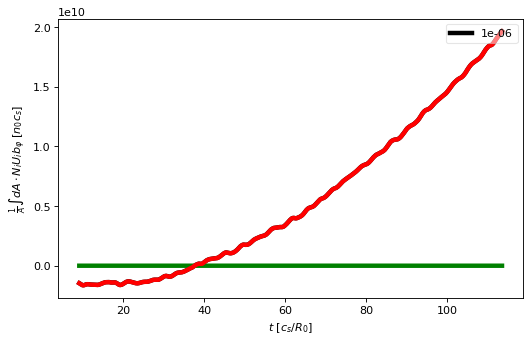

Invert for given numerical parameters


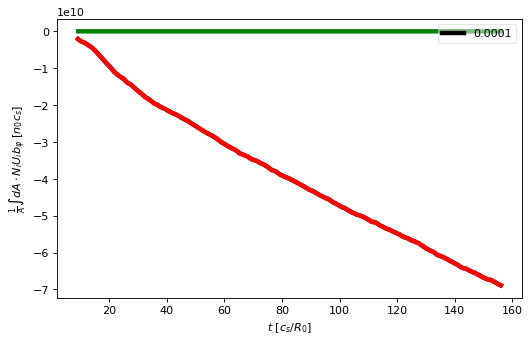

Invert for given numerical parameters


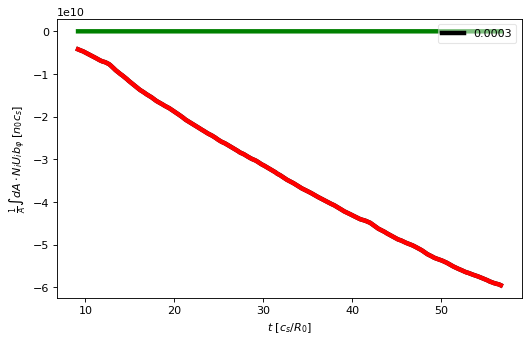

Invert for given numerical parameters


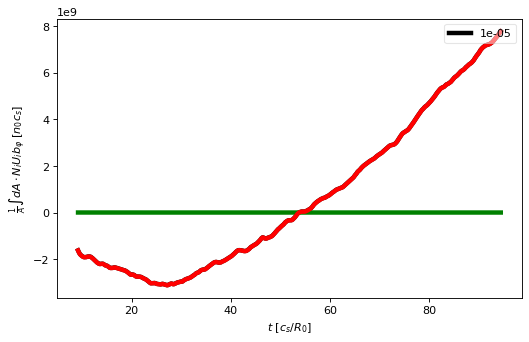

In [20]:
for file in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
    dset = create_merged_dataset( diag, file)
    params = json.loads( dset.inputfile )
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = dset.variables['time'][:]*timescale
    
    niuibphi = dset.variables['niuibphi_ifs_lcfs'][:]
    oexb = dset.variables['oexbi_ifs_lcfs'][:]

    plt.plot(time[min_idx:],niuibphi[min_idx:], color='k', 
             marker='',ls='-', lw=4,markeredgecolor='k', markersize=8, 
             label=f'{params["physical"]["resistivity"]}')
    plt.plot(time[min_idx:],oexb[min_idx:], color='g', 
         marker='',ls='-', lw=4,markeredgecolor='k', markersize=8
         )
    plt.plot(time[min_idx:],niuibphi[min_idx:]-oexb[min_idx:], color='r', 
         marker='',ls='-', lw=4,markeredgecolor='r', markersize=8
         )

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    da.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")
    plt.ylabel(r"$\frac{1}{A}\int dA \cdot N_iU_ib_\varphi\ [n_0c_s]$")

    plt.show(   )

### Ion toroidal momentum accuracy

Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  -5719.327271172404


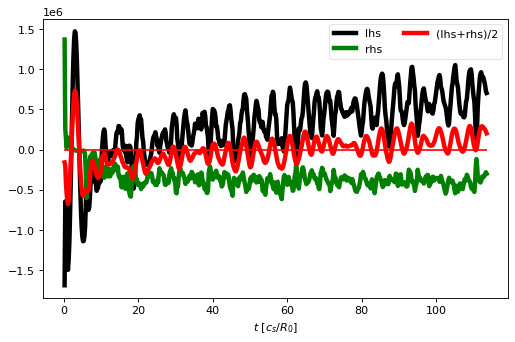

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  -1097201.1307232454


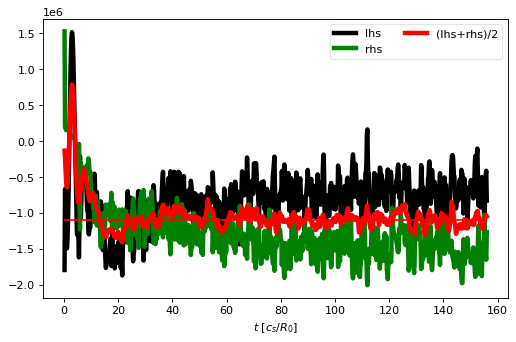

Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  -1492630.8163377547


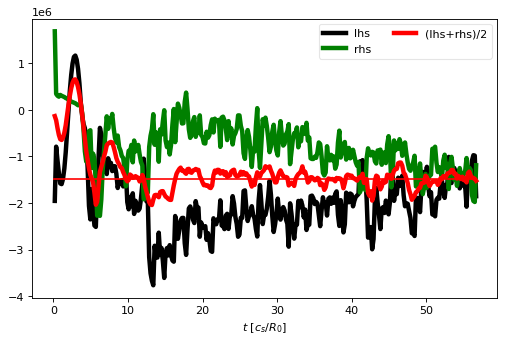

Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  -212789.26128909172


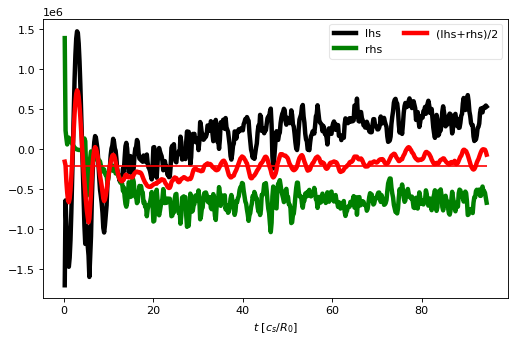

In [21]:
for file in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
    dset = create_merged_dataset( diag, file)
    params = json.loads( dset.inputfile )
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = dset.variables['time'][:]
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    
    mass =np.asarray(dset.variables['niuibphi_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat

    source = np.asarray(dset.variables['sparsnibphi_tt_ifs_lcfs'][:])/deltat
    deltamass-=source
    jvne= np.asarray(dset['jvparbphiexbi_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(dset['jvparbphiApar_tt_ifs_lcfs'][:])/deltat
    
    force = -np.asarray(dset.variables["socurve_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(dset.variables["socurvi_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(dset.variables["socurvkappae_tt_ifs_lcfs"][:])/deltat
    force -= np.asarray(dset.variables["socurvkappai_tt_ifs_lcfs"][:])/deltat
    rhs = jvne-force
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,deltamass[1:], color='k', marker='',
              ls='-', lw=4,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=4,markeredgecolor='g', markersize=8, label="rhs")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=4,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )

## Ion parallel momentum

Invert for given numerical parameters
Resistivity = 1e-06
timescale = 0.001834862385321101
Average diff =  -70.29263818052966


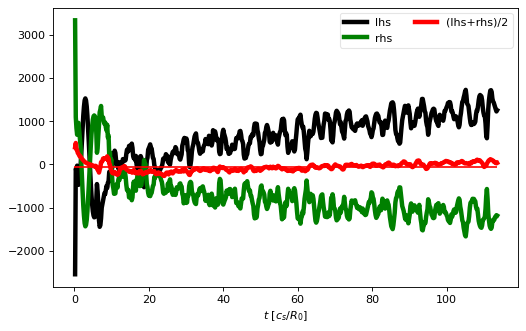

Invert for given numerical parameters
Resistivity = 0.0001
timescale = 0.001834862385321101
Average diff =  -1420.9904134974233


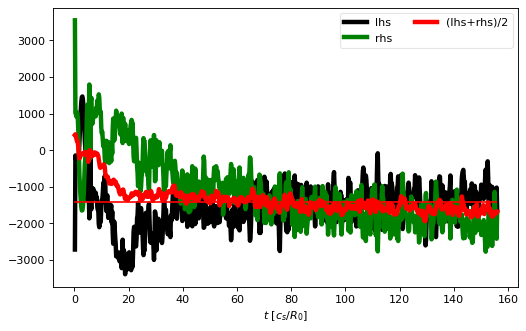

Invert for given numerical parameters
Resistivity = 0.0003
timescale = 0.001834862385321101
Average diff =  -1166.0559459395267


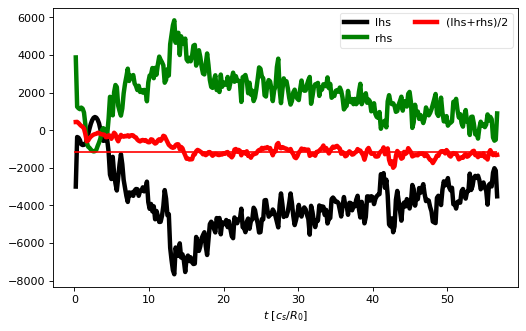

Invert for given numerical parameters
Resistivity = 1e-05
timescale = 0.001834862385321101
Average diff =  -415.82554211707713


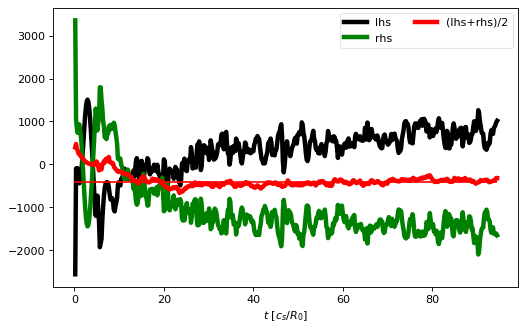

In [22]:
# content = []
# content.append( full_content[3])
for file in content :
    fig,ax=plt.subplots(1,1,figsize=(1.25*6,1.25*3.7),dpi= 80, facecolor='w', edgecolor='k')
    dset = create_merged_dataset( diag, file)
    params = json.loads( dset.inputfile )
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0
    time = dset.variables['time'][:]
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    
    mass =np.asarray(dset.variables['niui_ifs_lcfs'][:])
    masstt=np.append(np.zeros(1),mass, axis=0)
    deltamass = np.diff(masstt,axis=0)/deltat

    source = np.asarray(dset.variables['sparsni_tt_ifs_lcfs'][:])/deltat
    deltamass-=source
    jvne= np.asarray(dset['jvparexbi_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(dset['jvparApar_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(dset['jvpardiai_tt_ifs_lcfs'][:])/deltat
    jvne+=np.asarray(dset['jvparkappai_tt_ifs_lcfs'][:])/deltat
    divjpar = np.asarray(dset['divjpare_tt_ifs_lcfs'][:])/deltat
    divjpar += np.asarray(dset['divjpari_tt_ifs_lcfs'][:])/deltat
    force = np.asarray(dset.variables["sparmirrore_tt_ifs_lcfs"][:])/deltat
    force += np.asarray(dset.variables["sparmirrori_tt_ifs_lcfs"][:])/deltat
    rhs = jvne-force+divjpar
    diff = (deltamass + rhs)/2
   
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print(f'timescale = {timescale}')
    print( "Average diff = ", average_diff)
    plt.plot(time[1:]*timescale,deltamass[1:], color='k', marker='',
              ls='-', lw=4,markeredgecolor='k', markersize=8, label="lhs")
    plt.plot(time[1:]*timescale,rhs[1:], color='g', marker='',
              ls='-', lw=4,markeredgecolor='g', markersize=8, label="rhs")
    plt.plot(time[1:]*timescale,diff[1:], color='r', marker='',ls='-', 
              lw=4,markeredgecolor='r', markersize=8, label="(lhs+rhs)/2")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )

## Parallel electron force balance

Invert for given numerical parameters
Resistivity = 1e-06
Average diff =  -2395.062030170115


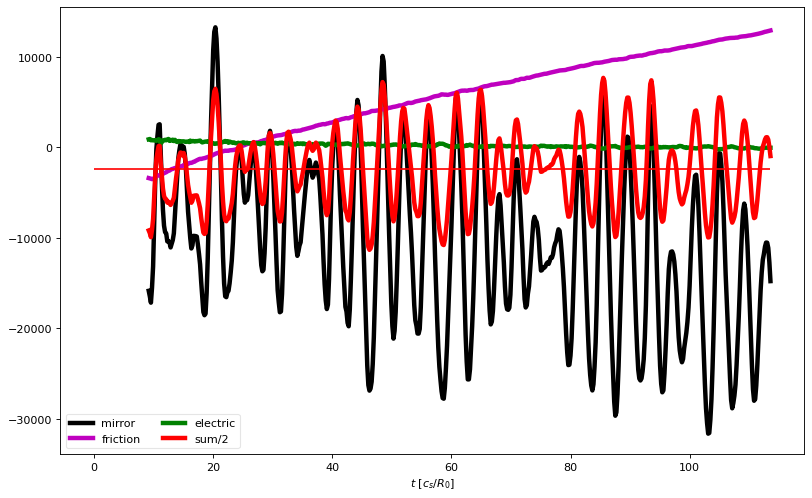

Invert for given numerical parameters
Resistivity = 0.0001
Average diff =  -244571.3696873308


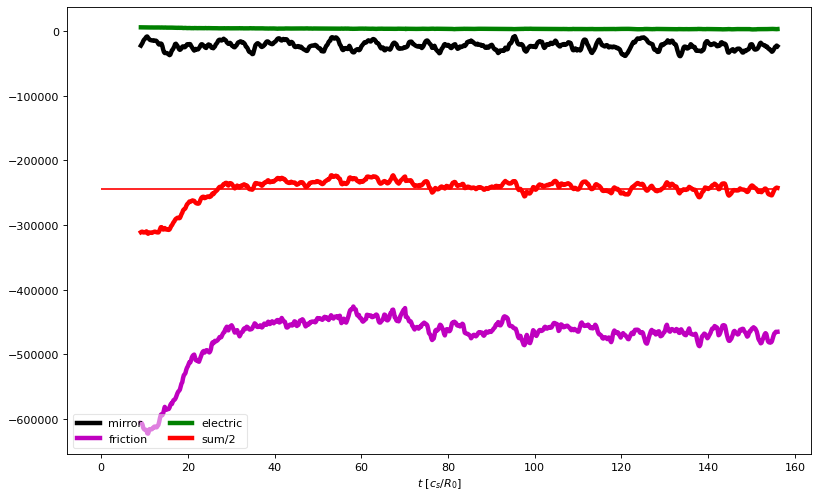

Invert for given numerical parameters
Resistivity = 0.0003
Average diff =  -712434.3901668037


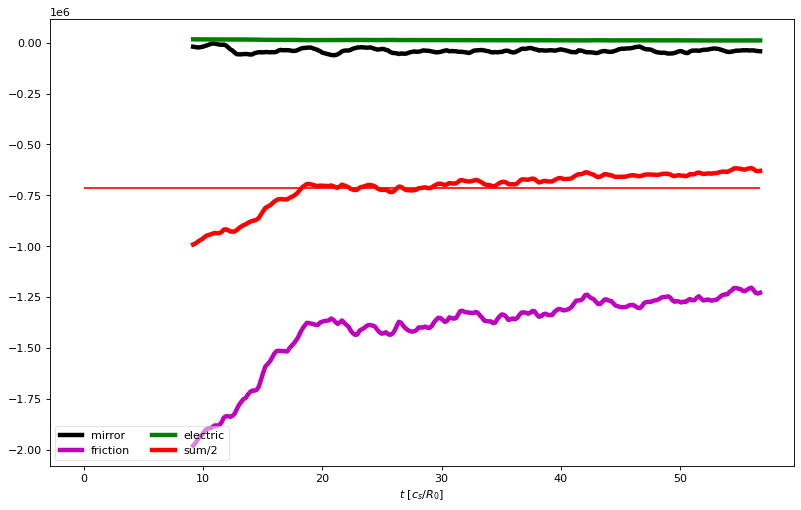

Invert for given numerical parameters
Resistivity = 1e-05
Average diff =  -11404.47190295726


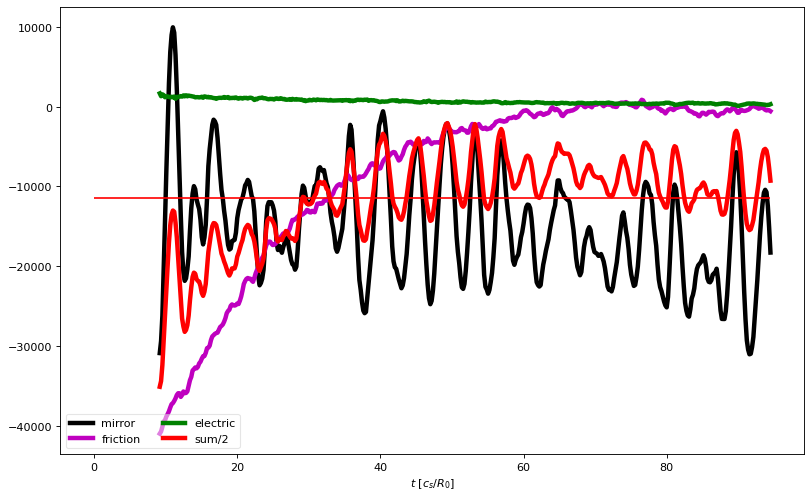

In [23]:

for file in content :
    fig,ax=plt.subplots(1,1,figsize=(2*6,2*3.7),dpi= 80, facecolor='w', edgecolor='k')
    #dset = Dataset( diag.outfile(file), 'r')
    dset = create_merged_dataset( diag, file)
    #print( dset)
    params = json.loads( dset.inputfile )
    time = np.asarray(dset['time'][:])
    timett = np.append(time, 2*time[len(time)-1] -time[len(time)-2]) # extrapolate
    deltat = np.diff(timett)
    num = {"R_0" : params["magnetic_field"]['params']["R_0"], **params["physical"]}
    fp.numerical2physical( num, params['physical'])
#     timescale = fp.omega_0_inv(**params['physical'])*1e3 # in ms
    timescale = 1/num['R_0']# in cs/R_0  
    mass =np.asarray(dset['sparmirrore_tt_ifs_lcfs'][:])
    mass+=np.asarray(dset['sparmirrorAe_tt_ifs_lcfs'][:])
    source =np.asarray(dset.variables['friction_tt_ifs_lcfs'][:])

    jvne = np.asarray(dset.variables['sparphie_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(dset.variables['sparphiAe_tt_ifs_lcfs'][:])/deltat
    jvne+= np.asarray(dset.variables['sparphiAe_tt_ifs_lcfs'][:])/deltat
    lhs = mass + source
    rhs = jvne
    diff = (lhs + rhs)/2
   
    average_diff = np.mean(diff[min_idx:])
    
    print(f'Resistivity = {params["physical"]["resistivity"]}')
    print( "Average diff = ", average_diff)
    plt.plot(time[min_idx:]*timescale,mass[min_idx:], color='k', marker='',
              ls='-', lw=4,markeredgecolor='k', markersize=8, label="mirror")
    plt.plot(time[min_idx:]*timescale,source[min_idx:], color='m', marker='',
              ls='-', lw=4,markeredgecolor='m', markersize=8, label="friction")
    plt.plot(time[min_idx:]*timescale,rhs[min_idx:], color='g', marker='',
              ls='-', lw=4,markeredgecolor='g', markersize=8, label="electric")
    plt.plot(time[min_idx:]*timescale,diff[min_idx:], color='r', marker='',ls='-', 
              lw=4,markeredgecolor='r', markersize=8, label="sum/2")
    plt.hlines(average_diff, time[0]*timescale, time[len(time)-1]*timescale, color='r')
#     plt.plot(time[min_idx:]*timescale,divjvnepar[min_idx:], color='g', marker='',
#              ls='--', lw = 4, label="parallel")
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, labels, loc='lower left',numpoints=1,ncol=2,
                   fontsize='medium',framealpha=0.5)
    dset.close()
    
    plt.xlabel(r"$t\ [c_s/R_0]$")

    plt.show(   )